In [31]:
import numpy as np

import matplotlib.pyplot as plt

# Example: Single Pendulum

$$ 
\begin{align*}
\mathbb{L} &= T - V \\
&= \frac{1}{2}ml^2\dot{\theta}^2 + mgl \cos{\theta}
\end{align*}$$

which can be used below to give the 2nd-order ode that governs the dynamics of the system.

$$ 
\begin{align*}
&\frac{d}{dt} \left(  \frac{\partial L}{\partial \dot{\theta}}  \right) -  \frac{\partial L}{\partial \theta} = 0 \\
\implies & ml^2 \ddot{\theta} + mgl \sin{\theta} = 0
\end{align*}$$

Ideally when simulating the control of this system we could actually use a physical copy and the system and sensors to get state information. In many circumstances this is not possible. Instead we simulate the system.

It is important to note that to do this we are required to work in discrete time-steps and hence approximate the system. The code below illustrates the resulting artifacts.  

**Euler's**:

$$ \dot{\theta}_{k+1} = \dot{\theta}_k + \ddot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$

$$ \theta_{k+1} = \theta_k + \dot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$



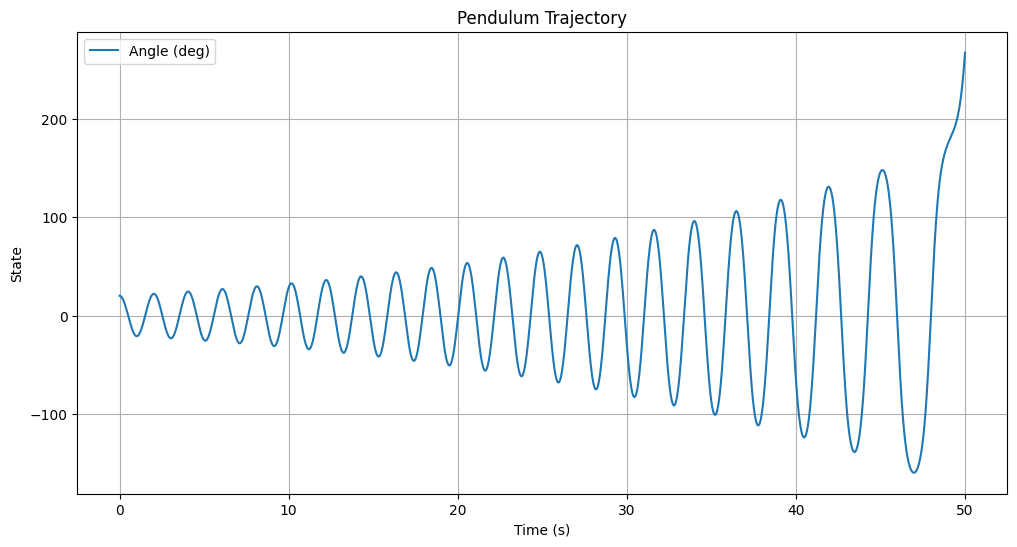

In [32]:
def euler_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = -(g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot * dt
    return np.array([theta_new, theta_dot_new])


t_span = (0, 50)
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Simulate pendulum trajectory
control_input = np.zeros_like(0.5 * np.sin(t_eval))
theta_start = np.deg2rad(20)
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
trajectory = np.zeros((t_eval.shape[0], 2))
trajectory[0] = x_start

for i in range(1, t_eval.shape[0]):
    trajectory[i] = euler_dynamics(trajectory[i - 1], control_input[i - 1], dt=dt)

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

Here we observe that the first order taylor expansion introduces a violation of the conservation of energy.

This can be proven by calculating the energy of the system at each time step.

In [33]:
gp = 1 * 9.81 * (1 + np.cos(trajectory[:, 0]))
ke = 0.5 * 1 * trajectory[:, 1] ** 2
total_energy = gp + ke

print(total_energy.max() / total_energy[0])

2.053478071847938


We now move on to a method that has a bounded error on the energy.

**Sympletic Integrator**:

$$ \dot{\theta}_{k+1} = \dot{\theta}_k + \ddot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$

$$ \theta_{k+1} = \theta_k + \dot{\theta}_{k+1} \Delta t + \mathcal{O}(\Delta t^2)$$

If you're familiar with Hamiltonians, then this scheme conserves these properties of the system's slightly perturbed Hamiltonian:
- Volume in phase space (Liouville's theorem)
- Geometric structure of phase space

[This](https://en.wikipedia.org/wiki/Geometric_integrator) page has a nice example of what this means with a pendulum.

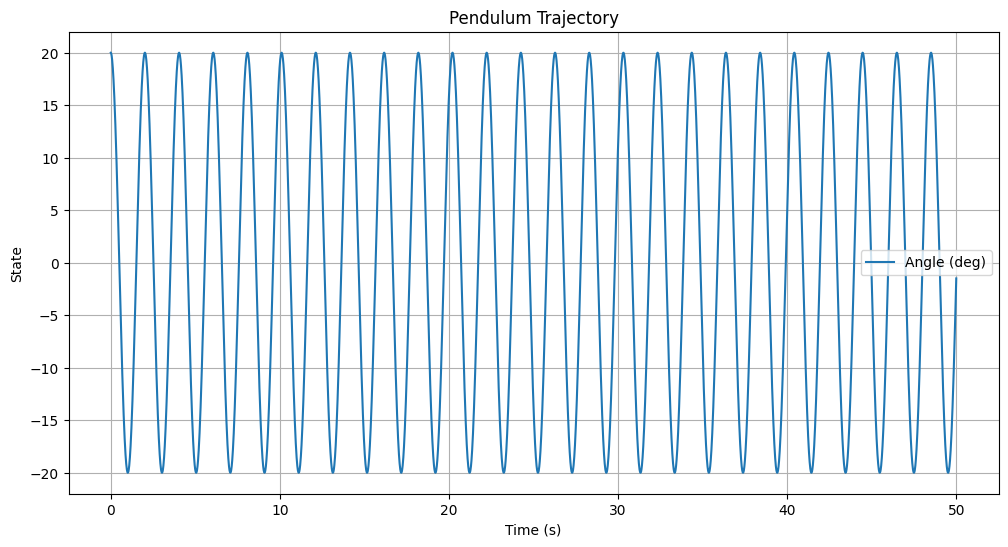

In [34]:
def symplectic_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = -(g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot_new * dt
    return np.array([theta_new, theta_dot_new])


# Simulate pendulum trajectory
trajectory = np.zeros((t_eval.shape[0], 2))
trajectory[0] = x_start

for i in range(1, t_eval.shape[0]):
    trajectory[i] = symplectic_dynamics(trajectory[i - 1], control_input[i - 1], dt=dt)

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
gp = 1 * 9.81 * (1 + np.cos(trajectory[:, 0]))
ke = 0.5 * 1 * trajectory[:, 1] ** 2
total_energy = gp + ke

print(total_energy.max() / total_energy[0])

1.062186068036128


As shown above the error is far more acceptable.

Whilst numerical ODEs arent the focus of these notebooks, this serves as a useful reminder to always understand the approximations you have made and the problems they could cause later on.

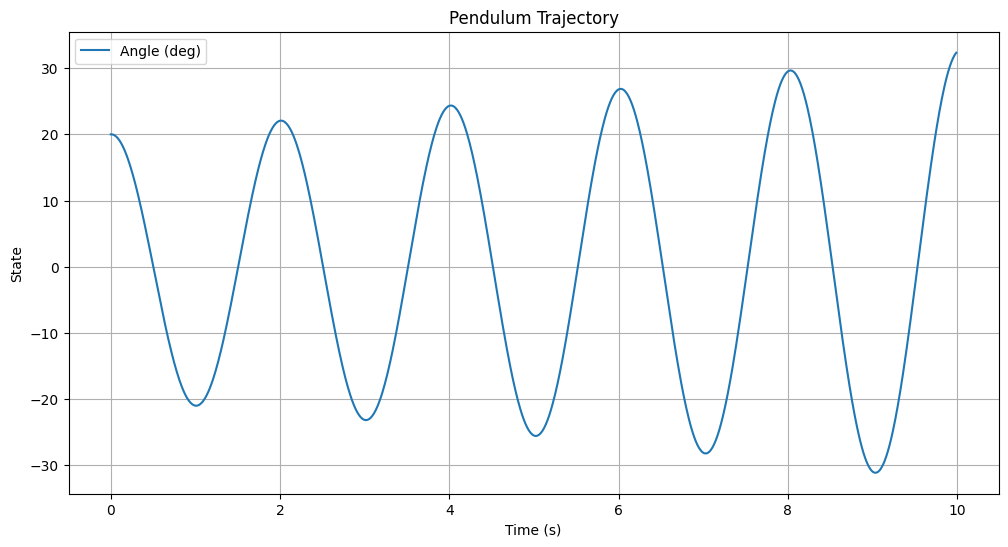

In [36]:
def linearize_pendulum_dynamics(length=1.0, g=9.81, dt=0.01):
    A_cont = np.array([[0, 1], [-g / length, 0]])
    B_cont = np.array([[0], [1 / (length**2)]])

    # Discretize using Euler method
    A_disc = np.eye(2) + A_cont * dt
    B_disc = B_cont * dt
    return A_disc, B_disc


# Simulate pendulum trajectory
theta_start = np.deg2rad(20)  # Convert 5 degrees to radians
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
time = 10  # Number of simulation steps
dt = 0.01  # Time step
steps = int(time / dt)
trajectory = np.zeros((steps, 2))
trajectory[0] = x_start

A, B = linearize_pendulum_dynamics(length=1.0, g=9.81, dt=dt)

for i in range(1, steps):
    u = 0  # 0.5 * np.sin(i * dt)
    trajectory[i] = A @ trajectory[i - 1] + (B * u).flatten()


# Plot the pendulum trajectory
time = np.arange(steps) * dt  # Time array in seconds
plt.figure(figsize=(12, 6))
plt.plot(time, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()